# Experiments on CIFAR10

In [1]:
from optimizers import *

import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

#import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
batch_size = 4
file_path = "./CIFAR10"

Вот здесь большая часть кода, откуда взята реализация (официальный репо pytorch)
https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py

Реализация VGG https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

## Data

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

In [7]:
batchs_per_epoch = len(trainloader) / batch_size

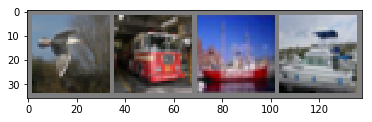

 bird	truck	 ship	 ship


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Models

### Cifarnet

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### VGG16

In [10]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
              512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 
              'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


#def test():
#    net = VGG('VGG16')
#    x = torch.randn(2,3,32,32)
#    y = net(x)
#    print(y.size())

## Train

In [11]:
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [12]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [13]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             }
    return states

In [14]:
print_every = 2
n_epochs = 8
tr_loss = {}
tr_loss['accSGD'] = {}
tr_loss['Adam'] = {}
tr_loss['amsgrad'] = {}
tr_loss['sug'] = {}
tr_loss['A2GradInc'] = {}
tr_loss['A2GradUni'] = {}
tr_loss['A2GradExp'] = {}
val_loss = {}
val_loss['accSGD'] = {}
val_loss['Adam'] = {}
val_loss['amsgrad'] = {}
val_loss['sug'] = {}
val_loss['A2GradInc'] = {}
val_loss['A2GradUni'] = {}
val_loss['A2GradExp'] = {}
lrs = [0.001]
criterion = nn.CrossEntropyLoss(reduction="mean")

## CNN

#### Adam

In [21]:
for lr in lrs:
    model = CNN()
    print("Adam  lr={}:".format(lr))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_loss['Adam'][lr], times, val_loss['Adam'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['Adam'][lr],
            'val_loss' : val_loss['Adam'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/CNN_Adam_' + str(lr))

Adam  lr=0.001:
Epoch 0, training loss 1.5619059246936702, time passed 0m 55s
Validation loss 1.395797265600115
Epoch 2, training loss 1.1838692916088727, time passed 3m 6s
Validation loss 1.2989325432251968
Epoch 4, training loss 1.0678610850366796, time passed 5m 16s
Validation loss 1.2283723291124962
Epoch 6, training loss 0.9927264514771228, time passed 7m 27s
Validation loss 1.1363938888982177


#### AMSgrad

In [22]:
for lr in lrs:
    model = CNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
    tr_loss['amsgrad'], times, val_loss['amsgrad'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                                         
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['amsgrad'],
            'val_loss' : val_loss['amsgrad'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './CIFAR10/CNN_amsgrad')

Epoch 0, training loss 1.5522522529031721, time passed 0m 57s
Validation loss 1.3503651137731119
Epoch 2, training loss 1.120953838430704, time passed 3m 9s
Validation loss 1.127311502125118
Epoch 4, training loss 0.9526293033156095, time passed 5m 19s
Validation loss 1.1745965771671294
Epoch 6, training loss 0.8406512876944504, time passed 7m 36s
Validation loss 1.04886676289992


#### Accelerated SGD

In [25]:
model = CNN()
optimizer = AccSGD(model.parameters(), lr=0.001, kappa = 1000.0, xi = 10.0)
tr_loss['accSGD'], times, val_loss['accSGD'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                          
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['accSGD'],
            'val_loss' : val_loss['accSGD'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './CIFAR10/CNN_accSGD')

Epoch 0, training loss 1.8840586420664767, time passed 0m 46s
Validation loss 1.8811800922629927
Epoch 2, training loss 1.2625865861549075, time passed 2m 33s
Validation loss 1.6384652144372018
Epoch 4, training loss 1.0880282887212753, time passed 4m 1s
Validation loss 1.2731956700568774
Epoch 6, training loss 0.9781017270982715, time passed 5m 28s
Validation loss 1.1477524315184946


#### Adaptive SGD

In [15]:
for lr in lrs:
    model = CNN()
    optimizer = SUG(model.parameters(), l_0=lr, momentum=0, nesterov=False)
    tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './CIFAR10/CNN_sug')

Epoch 0, training loss 1.7160492355469614, time passed 3m 5s
Validation loss 1.4749174501146554
Epoch 2, training loss 1.2525665010662232, time passed 7m 19s
Validation loss 1.2477889744487363
Epoch 4, training loss 1.067492834749598, time passed 11m 4s
Validation loss 1.1675659322687757
Epoch 6, training loss 0.9256623194171453, time passed 15m 5s
Validation loss 1.1762307366731963


#### A2GradInc 

In [18]:
for lr in lrs:
    model = CNN()
    print('A2GradInc')
    optimizer = A2GradInc(model.parameters(), beta=5, lips=10)
    tr_loss['A2GradInc'][lr], times, val_loss['A2GradInc'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradInc'][lr],
            'val_loss' : val_loss['A2GradInc'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/CNN_A2GradInc')

A2GradInc
Epoch 0, training loss 1.8954763923580926, time passed 0m 41s
Validation loss 1.7763475310713404
Epoch 2, training loss 1.6979682360360602, time passed 2m 27s
Validation loss 1.712695634861257
Epoch 4, training loss 1.622521726933521, time passed 4m 2s
Validation loss 1.5941723119805438
Epoch 6, training loss 1.5578404663226018, time passed 5m 40s
Validation loss 1.5549846551397948


#### A2GradExp

In [19]:
for lr in lrs:
    model = CNN()
    print("A2GradExp  lr={}:".format(lr))
    optimizer = A2GradExp(model.parameters(), beta=5, lips=10, rho=0.99)
    tr_loss['A2GradExp'][lr], times, val_loss['A2GradExp'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradExp'][lr],
            'val_loss' : val_loss['A2GradExp'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/CNN_A2GradExp')

A2GradExp  lr=0.001:
Epoch 0, training loss 1.9450582547607012, time passed 0m 41s
Validation loss 1.8914221327676335
Epoch 2, training loss 1.8010226714492112, time passed 2m 16s
Validation loss 1.7759289370656903
Epoch 4, training loss 1.7448809497697975, time passed 3m 53s
Validation loss 1.678396025233233
Epoch 6, training loss 1.6877969361291862, time passed 21m 36s
Validation loss 1.6874131423559362


#### A2GradUni

In [20]:
for lr in lrs:
    model = CNN()
    print("A2GradUni  lr={}:".format(lr))
    optimizer = A2GradUni(model.parameters(), beta=5, lips=10,)
    tr_loss['A2GradUni'][lr], times, val_loss['A2GradUni'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradUni'][lr],
            'val_loss' : val_loss['A2GradUni'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/CNN_A2GradUni')

A2GradUni  lr=0.001:
Epoch 0, training loss 1.885427249954587, time passed 0m 44s
Validation loss 1.7669530588509306
Epoch 2, training loss 1.6846244645877235, time passed 2m 28s
Validation loss 1.6855964011481885
Epoch 4, training loss 1.6142121050534881, time passed 4m 2s
Validation loss 1.5925247664130993
Epoch 6, training loss 1.5519584719013109, time passed 5m 45s
Validation loss 1.5557561303978924


## VGG

#### Adam

In [25]:
for lr in lrs:
    model = VGG('VGG16')
    print("Adam  lr={}:".format(lr))
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tr_loss['Adam'][lr], times, val_loss['Adam'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['Adam'][lr],
            'val_loss' : val_loss['Adam'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/VGG_Adam_' + str(lr))

Adam  lr=0.001:


#### AMSgrad

In [ ]:
for lr in lrs:
    model = VGG('VGG16')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8, amsgrad=True)
    tr_loss['amsgrad'], times, val_loss['amsgrad'], lips, grad = train(model, trainloader, criterion, optimizer, 
                                                           n_epochs=n_epochs, print_every=print_every, 
                                                           validloader=validloader)
                                                         
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['amsgrad'],
            'val_loss' : val_loss['amsgrad'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
    torch.save(states, './CIFAR10/VGG_amsgrad')

#### A2GradInc 

In [ ]:
for lr in lrs:
    model = VGG('VGG16')
    print('A2GradInc')
    optimizer = A2GradInc(model.parameters())
    tr_loss['A2GradInc'][lr], times, val_loss['A2GradInc'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradInc'][lr],
            'val_loss' : val_loss['A2GradInc'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/VGG_A2GradInc')

#### A2GradExp

In [ ]:
for lr in lrs:
    model = VGG('VGG16')
    print("A2GradExp  lr={}:".format(lr))
    optimizer = A2GradExp(model.parameters())
    tr_loss['A2GradExp'][lr], times, val_loss['A2GradExp'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradExp'][lr],
            'val_loss' : val_loss['A2GradExp'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/VGG_A2GradExp')

#### A2GradUni

In [ ]:
for lr in lrs:
    model = VGG('VGG16')
    print("A2GradUni  lr={}:".format(lr))
    optimizer = A2GradUni(model.parameters())
    tr_loss['A2GradUni'][lr], times, val_loss['A2GradUni'][lr], lips, grad = train(model, trainloader, criterion, 
                                                                         optimizer, n_epochs=n_epochs, 
                                                                         print_every=print_every, 
                                                                         validloader=validloader)
    states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['A2GradUni'][lr],
            'val_loss' : val_loss['A2GradUni'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
    torch.save(states, './CIFAR10/VGG_A2GradUni')